# Hand gesture classification based on CNN



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd # version 0.24.2
import numpy as np #version 1.16.4
import random
import matplotlib.pyplot as plt #matplotlib version 3.1.0
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns #version 0.9.0
from sklearn.model_selection import GridSearchCV
import math 

In [5]:
Window_time=100
Perc = 25
window_length = math.floor(Window_time*2048/1000)
stride_length = math.floor(window_length*(Perc/100))
print(window_length,stride_length)

204 51


## Import the Datasets

In [6]:
N_Subj = 1
N_Days = 1
N_rounds= 3
df= [[[0] * N_rounds]*N_Days]*N_Subj # dataframe for all rounds for all subjects for all days
print(df)
#making a header for dataframe
cl_names= []
for i in range(1,11):
    cl_names.append('CH'+str(i))
cl_names.append('class') #column dedicated to show which class of movement this sample belongs to
cl_names.append('move') #column dedicated to show which number of movement (out of 40 in each round) this sample belongs to
cl_names.append('window')
for i in range(0,N_Subj):
  for j in range(0,N_Days):  
   for k in range(0,N_rounds):
    df[i][j][k] = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NEURO_PROJECT/FINAL DATA _ SUB1_DAY1/data/sbj'+str(i+1)+'_day'+str(j+1)+'_round'+str(k+1)+'_'+ str(Window_time)+'_'+str(Perc)+'.csv')
    df[i][j][k].columns=cl_names
    print("subj"+str(i+1)+"_day"+str(j+3)+"_Round"+str(k+1))
    print("Round1",np.shape(df[i][j][k]))

[[[0, 0, 0]]]
subj1_day3_Round1
Round1 (1434120, 13)
subj1_day3_Round2
Round1 (1478796, 13)
subj1_day3_Round3
Round1 (1446360, 13)


In [7]:
#Day1_Subject2_Round1 shape
df[0][0][0].head(10)

,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,class,move,window
0,-0.037422,-0.066970,-0.004722,-0.002298,0.009147,0.000264,0.030113,0.001229,-0.000046,0.024452,1,1,1
1,-0.027106,-0.069792,-0.003393,-0.001506,0.015246,0.010729,0.033083,0.002324,-0.017275,0.012365,1,1,1
2,-0.018335,-0.070210,-0.001637,-0.002423,0.015040,0.023082,0.037320,0.002860,-0.020864,0.027658,1,1,1
3,-0.012485,-0.066842,0.000101,-0.004762,0.013541,0.041201,0.037835,0.003687,-0.014293,0.056742,1,1,1
4,-0.004825,-0.060419,0.001824,-0.007347,0.013795,0.064046,0.031025,0.005208,-0.004321,0.062703,1,1,1
5,0.005364,-0.052430,0.003509,-0.008223,0.016031,0.087142,0.019538,0.006902,0.002390,0.029969,1,1,1
6,0.013969,-0.041837,0.003704,-0.006084,0.019951,0.097848,0.008052,0.007150,0.001886,-0.007631,1,1,1
7,0.018151,-0.027799,0.002206,-0.001399,0.023652,0.086413,-0.001507,0.006514,-0.002337,-0.010484,1,1,1
8,0.018671,-0.013399,0.001423,0.003602,0.024873,0.056382,-0.009276,0.007735,-0.002523,0.016994,1,1,1
9,0.016108,-0.001753,0.002477,0.005507,0.021791,0.019488,-0.013920,0.009651,0.004802,0.048708,1,1,1


## Data exploration

In [8]:
#Print class freq for each round of subject 1
# classes are from 1 to 8: 1 Flex, 2 Ext, 3 Sup, 4 Pron, 5 Open, 6 Pinch, 7 Lateral pinch, 8 Fist
def Class_freq(df):
  target_dist=df.groupby('class').size()/window_length  #number of windows for each type
  print(target_dist)
  print(type(target_dist))
print("rounds class distribution")
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
     print("Class frequency for subject "+str(i+1)+"day "+str(j+1)+ "round "+str(k+1))
     Class_freq(df[i][j][k])

rounds class distribution
Class frequency for subject 1day 1round 1
class
1    880.0
2    883.0
3    876.0
4    879.0
5    903.0
6    878.0
7    862.0
8    869.0
dtype: float64
<class 'pandas.core.series.Series'>
Class frequency for subject 1day 1round 2
class
1    913.0
2    907.0
3    883.0
4    906.0
5    921.0
6    900.0
7    896.0
8    923.0
dtype: float64
<class 'pandas.core.series.Series'>
Class frequency for subject 1day 1round 3
class
1    907.0
2    908.0
3    898.0
4    737.0
5    917.0
6    902.0
7    903.0
8    918.0
dtype: float64
<class 'pandas.core.series.Series'>


## **Train and Test separation**

In [9]:
#Train Test Seperation
df_train= [[[0] * N_rounds]*N_Days]*N_Subj # Train dataframe for all rounds for all subjects for all days
df_test = [[[0] * N_rounds]*N_Days]*N_Subj # Test dataframe for all rounds for all subjects for all days
def Train_Test_Sep(df):
  Trainset_class=[]
  Testset_class=[]
  for i in range(1,9):
    class_group = df.loc[df['class'] == i]
    Move_group=class_group.move.unique()
    Train1=df.loc[df['move'] ==Move_group[0]]
    Train2=df.loc[df['move'] ==Move_group[1]]
    Train3=df.loc[df['move'] ==Move_group[2]]
    Test1=df.loc[df['move'] ==Move_group[3]]
    if len(Move_group)==5:
      Test2=df.loc[df['move'] ==Move_group[4]]
      Testset_class.append(pd.concat((Test1,Test2)))
    else:
      Testset_class.append(Test1)
    Trainset_class.append(pd.concat((Train1,Train2,Train3)))
  Trainset=Trainset_class[0]
  Testset=Testset_class[0]

  for i in range(1,8):
    Trainset=np.vstack((Trainset,Trainset_class[i]))
    Testset=np.vstack((Testset,Testset_class[i]))
  df_Train = pd.DataFrame(data=Trainset, columns=cl_names)
  df_Test =  pd.DataFrame(data=Testset, columns=cl_names)
  return df_Train,df_Test
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      df_train[i][j][k],df_test[i][j][k] =Train_Test_Sep(df[i][j][k])

In [10]:
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      print("Train Class frequency for subject "+str(i+1)+"day "+str(j+1)+ "round "+str(k+1))
      Class_freq(df_train[i][j][k])

Train Class frequency for subject 1day 1round 1
class
1.0    526.0
2.0    537.0
3.0    531.0
4.0    535.0
5.0    557.0
6.0    539.0
7.0    518.0
8.0    521.0
dtype: float64
<class 'pandas.core.series.Series'>
Train Class frequency for subject 1day 1round 2
class
1.0    552.0
2.0    545.0
3.0    531.0
4.0    549.0
5.0    558.0
6.0    545.0
7.0    540.0
8.0    555.0
dtype: float64
<class 'pandas.core.series.Series'>
Train Class frequency for subject 1day 1round 3
class
1.0    545.0
2.0    549.0
3.0    547.0
4.0    548.0
5.0    560.0
6.0    533.0
7.0    542.0
8.0    560.0
dtype: float64
<class 'pandas.core.series.Series'>


In [11]:
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      print("Test Class frequency for subject "+str(i+1)+"day "+str(j+1)+ "round "+str(k+1))
      Class_freq(df_test[i][j][k])

Test Class frequency for subject 1day 1round 1
class
1.0    354.0
2.0    346.0
3.0    345.0
4.0    344.0
5.0    346.0
6.0    339.0
7.0    344.0
8.0    348.0
dtype: float64
<class 'pandas.core.series.Series'>
Test Class frequency for subject 1day 1round 2
class
1.0    361.0
2.0    362.0
3.0    352.0
4.0    357.0
5.0    363.0
6.0    355.0
7.0    356.0
8.0    368.0
dtype: float64
<class 'pandas.core.series.Series'>
Test Class frequency for subject 1day 1round 3
class
1.0    362.0
2.0    359.0
3.0    351.0
4.0    189.0
5.0    357.0
6.0    369.0
7.0    361.0
8.0    358.0
dtype: float64
<class 'pandas.core.series.Series'>


## Create a 3D rappresentation

In [12]:
def _3D_representation(df):
  T=df.shape[0]
  p=int(T/window_length)
  print(p)
  df_3d = np.zeros((window_length, 13,p))
  df_3d[:,:,0]=df[0:window_length]  
  s=0
  i=0
  while s<T:    
    df_3d[:,:,i]=df[s:s+window_length]
    s=s+window_length
    i+=1
  return df_3d

In [13]:
df_Train_3d=[[[0] * N_rounds]*N_Days]*N_Subj
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      df_Train_3d[i][j][k]= _3D_representation(df_train[i][j][k])
print(df_Train_3d[0][0][0])

4264
4375
4384
[[[-3.7422e-02  2.6647e-02 -7.5255e-03 ...  4.8626e-02 -2.4397e-01
   -2.4453e-01]
  [-6.6970e-02  1.8986e-02 -6.8304e-02 ...  6.5525e-02 -7.0985e-02
   -1.2104e-02]
  [-4.7220e-03  4.4102e-03 -1.1789e-02 ...  2.3338e-02 -2.6937e-02
    1.5493e-02]
  ...
  [ 1.0000e+00  1.0000e+00  1.0000e+00 ...  8.0000e+00  8.0000e+00
    8.0000e+00]
  [ 1.0000e+00  1.0000e+00  1.0000e+00 ...  2.2000e+01  2.2000e+01
    2.2000e+01]
  [ 1.0000e+00  2.0000e+00  3.0000e+00 ...  3.8840e+03  3.8850e+03
    3.8860e+03]]

 [[-2.7106e-02  1.3596e-02  7.7599e-03 ...  4.4818e-02 -1.7503e-01
   -2.9992e-01]
  [-6.9792e-02  1.6916e-02 -6.4162e-02 ...  3.8007e-02 -7.1270e-02
   -3.1763e-02]
  [-3.3929e-03  6.4770e-03 -3.1845e-03 ...  1.7588e-02 -3.2901e-02
   -5.9464e-03]
  ...
  [ 1.0000e+00  1.0000e+00  1.0000e+00 ...  8.0000e+00  8.0000e+00
    8.0000e+00]
  [ 1.0000e+00  1.0000e+00  1.0000e+00 ...  2.2000e+01  2.2000e+01
    2.2000e+01]
  [ 1.0000e+00  2.0000e+00  3.0000e+00 ...  3.8840e+03  3.

In [14]:
Train_final_3d= df_Train_3d[0][0][0]
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      if i+j+k :
        Train_final_3d=np.concatenate([Train_final_3d, df_Train_3d[i][j][k]], -1)
Train_final_3d.shape     

(204, 13, 13023)

In [15]:
df_Test_3d=[[[0] * N_rounds]*N_Days]*N_Subj
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
       df_Test_3d[i][j][k]= _3D_representation(df_test[i][j][k])
print(df_Test_3d[0][0][0].shape)

2766
2874
2706
(204, 13, 2766)


In [16]:
Test_final_3d= df_Test_3d[0][0][0]
for i in range(0,N_Subj):
  for j in range(0,N_Days):
    for k in range(0,N_rounds):
      if i+j+k :
        Test_final_3d=np.concatenate([Test_final_3d, df_Test_3d[i][j][k]], -1)
Test_final_3d.shape

(204, 13, 8346)

EXTRACTING FEATURES


In [17]:
x=Train_final_3d[:,0:10]
x.shape

(204, 10, 13023)

In [18]:
labels=Train_final_3d[1,-3,:]
labels.shape

(13023,)

In [19]:
mav=np.zeros((x.shape[2],10))
#
for i in range(0, x.shape[2]):
  for j in range(0, 10):
   mav[i][j]=np.mean(abs(x[:,j,i]))

In [20]:
mav=pd.DataFrame(mav)

In [21]:
labels=pd.DataFrame(labels)

In [22]:
wl=np.zeros((x.shape[2],10))
#
for i in range(0, x.shape[2]):
  for j in range(0, 10):
    for k in range (1, x.shape[0]):  
      wl[i][j]=wl[i][j] + abs(x[k,j,i]-x[k-1,j,i])

In [23]:
wl=pd.DataFrame(wl)

In [24]:
zc=np.zeros((x.shape[2],10))
#
for i in range(0, x.shape[2]):
  for j in range(0, 10):
    zc[i][j]=((x[:-1,j,i] * x[1:,j,i]) < 0).sum()

In [25]:
ssc=np.zeros((x.shape[2],10)) 
#
for i in range(0, x.shape[2]):
  for j in range(0, 10):
    ssc[i][j]=(((x[1:-1,j,i] - x[0:-2,j,i]) *( x[2:,j,i]-x[1:-1,j,i])) < 0).sum()

In [26]:
zc=pd.DataFrame(zc)

In [27]:
ssc=pd.DataFrame(ssc)

In [28]:
train=pd.concat([mav,wl,zc,ssc,labels],sort=False,axis=1)


In [29]:
train.columns = ['mav1', 'mav2', 'mav3', 'mav4', 'mav5', 'mav6', 'mav7', 'mav8', 'mav9', 'mav10',
               'wl1','wl2','wl3','wl4','wl5','wl6','wl7','wl8','wl9','wl10',
               'zc1','zc2','zc3','zc4','zc5','zc6','zc7','zc8','zc9','zc10',
               'ssc1','ssc2','ssc3','ssc4','ssc5','ssc6','ssc7','ssc8','ssc9','ssc10','class']

In [30]:
x1=Test_final_3d[:,0:10]
x1.shape

(204, 10, 8346)

In [31]:
labels1=Test_final_3d[1,-3,:]
labels1.shape

(8346,)

In [32]:
import time
t0= time.clock()

In [33]:
mav1=np.zeros((x1.shape[2],10))
#
for i in range(0, x1.shape[2]):
  for j in range(0, 10):
   mav1[i][j]=np.mean(abs(x1[:,j,i]))

In [34]:
wl1=np.zeros((x1.shape[2],10))
#
for i in range(0, x1.shape[2]):
  for j in range(0, 10):
    for k in range (1, x1.shape[0]):  
      wl1[i][j]=wl1[i][j] + abs(x1[k,j,i]-x1[k-1,j,i])

In [35]:
zc1=np.zeros((x1.shape[2],10))
#
for i in range(0, x1.shape[2]):
  for j in range(0, 10):
    zc1[i][j]=((x1[:-1,j,i] * x1[1:,j,i]) < 0).sum()

In [36]:
ssc1=np.zeros((x1.shape[2],10)) 
#
for i in range(0, x1.shape[2]):
  for j in range(0, 10):
    ssc1[i][j]=(((x1[1:-1,j,i] - x1[0:-2,j,i]) *( x1[2:,j,i]-x1[1:-1,j,i])) < 0).sum()

In [37]:
tfeature = (time.clock() - t0)/x1.shape[2]
tfeature

0.002957367721063983

In [38]:
x1.shape[2]

8346

In [39]:
mav1=pd.DataFrame(mav1)

In [40]:
wl1=pd.DataFrame(wl1)

In [41]:
zc1=pd.DataFrame(zc1)

In [42]:
ssc1=pd.DataFrame(ssc1)

In [43]:
labels1=pd.DataFrame(labels1)

In [44]:
test=pd.concat([mav1,wl1,zc1,ssc1,labels1],sort=False,axis=1)

In [45]:
test.columns = ['mav1', 'mav2', 'mav3', 'mav4', 'mav5', 'mav6', 'mav7', 'mav8', 'mav9', 'mav10',
               'wl1','wl2','wl3','wl4','wl5','wl6','wl7','wl8','wl9','wl10',
               'zc1','zc2','zc3','zc4','zc5','zc6','zc7','zc8','zc9','zc10',
               'ssc1','ssc2','ssc3','ssc4','ssc5','ssc6','ssc7','ssc8','ssc9','ssc10','class']

In [46]:
train = train.sample(frac=1).reset_index(drop=True)

In [47]:
test = test.sample(frac=1).reset_index(drop=True)

In [48]:
X_train = train.iloc[:,0:-1]
column_names = list(X_train) 
y_train = train.iloc[:,-1]

In [49]:
X_test = test.iloc[:,0:-1]
column_names = list(X_test) 
y_test = test.iloc[:,-1]

# DECISION TREE

In [50]:
#DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID
from sklearn.tree import DecisionTreeClassifier
import numpy as np

classifier = DecisionTreeClassifier(criterion='entropy', max_depth= 8, min_samples_leaf= 1, min_samples_split= 6)   #we create a dictionary with all the possibilty I want to try


In [51]:
model = classifier.fit(X_train, y_train)

In [52]:
t0= time.clock()
y_pred = model.predict(X_test)
test_DTREE = (time.clock() - t0)/X_test.shape[0]
print("Time for a window : %e [s]" %(test_DTREE))

Time for a window : 3.731129e-07 [s]


0.9603402827701893


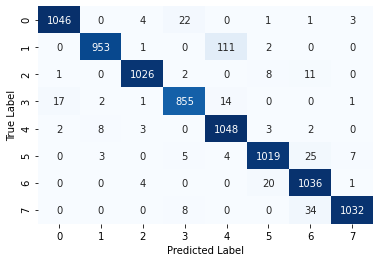

In [53]:
Dtree_acc = metrics.accuracy_score(y_test, y_pred)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
print(Dtree_acc)

# LDA


In [54]:
# grid search solver for lda
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from numpy import arange
# define model
classifier = LinearDiscriminantAnalysis(shrinkage= 0.0, solver= 'lsqr')

model = classifier.fit(X_train, y_train)


In [55]:
t0= time.clock()
y_pred = model.predict(X_test)
test_LDA = (time.clock() - t0)/X_test.shape[0]
print("Time for a window : %e [s]" %(test_LDA))

Time for a window : 1.417685e-06 [s]


0.9166067577282531


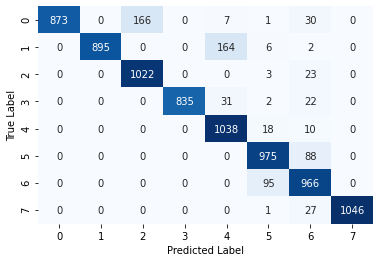

In [56]:
LDA_acc = metrics.accuracy_score(y_test, y_pred)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
print(LDA_acc)

# SVM

In [57]:
'''SVM '''

from sklearn.svm import SVC

classifier = SVC(C= 100, gamma= 0.0001, kernel= 'linear')

In [58]:
model = classifier.fit(X_train, y_train)

In [59]:
t0= time.clock()
y_pred = model.predict(X_test)
test_SVM = (time.clock() - t0)/X_test.shape[0]
print("Time for a window : %e [s]" %(test_SVM))

Time for a window : 2.565648e-05 [s]


0.9767553318955188


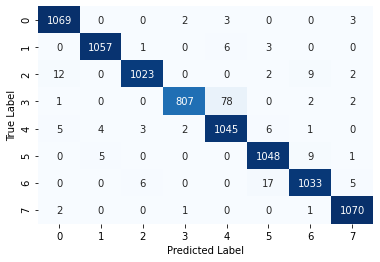

In [60]:
SVM_acc = metrics.accuracy_score(y_test, y_pred)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
print(SVM_acc)

# KNN

In [61]:
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 

classifier = KNeighborsClassifier(n_neighbors= 6, weights= 'distance')


In [62]:
model= classifier.fit(X_train, y_train)

In [63]:
t0= time.clock()
y_pred = model.predict(X_test)
test_KNN = (time.clock() - t0)/X_test.shape[0]
print("Time for a window : %e [s]" %(test_KNN))

Time for a window : 6.317752e-04 [s]


0.917685118619698


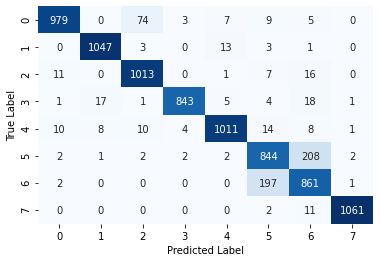

In [64]:
KNN_acc = metrics.accuracy_score(y_test, y_pred)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
print(KNN_acc)

# RANDOM FOREST

In [65]:
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(bootstrap= True, max_depth= 50, max_features= 3, min_samples_leaf= 2, min_samples_split= 4, n_estimators= 100)


In [66]:
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [67]:
X_test.shape[0]

8346

In [68]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 1 * np.mean(errors / test_labels)
    accuracy = 1 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = %f' %(accuracy))
    
    return accuracy

In [69]:
t0= time.clock()
RF_acc = evaluate(rf, X_test, y_test)
test_RF = (time.clock() - t0)/X_test.shape[0]
print("Time for a window : %e [s]" %(test_RF))


Model Performance
Average Error: 0.1561 degrees.
Accuracy = 0.938147
Time for a window : 9.675294e-06 [s]


In [70]:
print("Window Size [ms]: %f " % (Window_time))
print("Stride [perc]: %f " % (Perc))
print("%s best accuracy: %f " % ("DTree",Dtree_acc))
print("%s best accuracy: %f " % ("LDA",LDA_acc))
print("%s best accuracy: %f " % ("SVM",SVM_acc))
print("%s best accuracy: %f " % ("KNN",KNN_acc))
print("%s best accuracy: %f " % ("RF",RF_acc))

Window Size [ms]: 100.000000 
Stride [perc]: 25.000000 
DTree best accuracy: 0.960340 
LDA best accuracy: 0.916607 
SVM best accuracy: 0.976755 
KNN best accuracy: 0.917685 
RF best accuracy: 0.938147 


In [71]:
print(x.shape[2])

13023


In [72]:
time_DTREE=Window_time + (tfeature + test_DTREE)*1000
time_LDA=Window_time + (tfeature +test_LDA)*1000
time_SVM=Window_time + (tfeature +test_SVM)*1000
time_KNN=Window_time + (tfeature +test_KNN)*1000
time_RF=Window_time + (tfeature +test_RF)*1000

In [73]:
parameters = [Window_time,Perc,Dtree_acc,LDA_acc,KNN_acc,SVM_acc,RF_acc,time_DTREE,time_LDA,time_SVM,time_KNN,time_RF];
import csv
with open('/content/drive/MyDrive/Colab Notebooks/NEURO_PROJECT/ACCURACY_TIME_DATA/CLASSICAL/parameters_CLASSICAL_day1.csv', mode='a') as parameter_file:
  parameter_writer = csv.writer(parameter_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  parameter_writer.writerow(parameters)